# Lesson 3: Federated LLM Fine-tuning

Welcome to Lesson 3!

To access the `requirements.txt` and `utils` files for this course, go to `File` and click `Open`.

#### 1. Import packages and utilities

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import flwr as fl
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from datasets import load_dataset
from flwr.client.mod import fixedclipping_mod
from flwr.server.strategy import (
    DifferentialPrivacyClientSideFixedClipping
)
from utils.utils import * 
from utils.LLM import LLM_fl
from utils.LLM import get_fireworks_api_key,load_env

/usr/local/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


* Load configuration.

In [2]:
cfg = get_config("federated")

print_config(cfg)

dataset:
  name: medalpaca/medical_meadow_medical_flashcards
model:
  name: EleutherAI/pythia-70m
  quantization: 4
  gradient_checkpointing: true
  use_fast_tokenizer: true
  lora:
    peft_lora_r: 16
    peft_lora_alpha: 64
    target_modules: null
train:
  num_rounds: ${flower.num_rounds}
  save_every_round: 5
  learning_rate_max: 5.0e-05
  learning_rate_min: 1.0e-06
  seq_length: 512
  padding_side: left
  evaluate_split: false
  training_arguments:
    output_dir: null
    learning_rate: null
    disable_tqdm: true
    per_device_train_batch_size: 2
    gradient_accumulation_steps: 1
    logging_steps: 5
    num_train_epochs: 3
    max_steps: 1
    report_to: null
    save_steps: 1000
    save_total_limit: 10
    gradient_checkpointing: ${model.gradient_checkpointing}
    lr_scheduler_type: constant
flower:
  num_clients: 20
  num_rounds: 2
  fraction_fit: 0.2
  client_resources:
    num_cpus: 2
    num_gpus: 0.0
  dp:
    noise_mult: 0.02
    clip_norm: 0.5



#### 2. Dataset partition

In [3]:
partitioner = IidPartitioner(num_partitions=cfg.flower.num_clients)
fds = FederatedDataset(
    dataset=cfg.dataset.name,
    partitioners={"train": partitioner}
)

partition_zero = fds.load_partition(0) 

format_dataset(partition_zero)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['instruction', 'response'],
    num_rows: 1698
})

* Visualize the data partition.

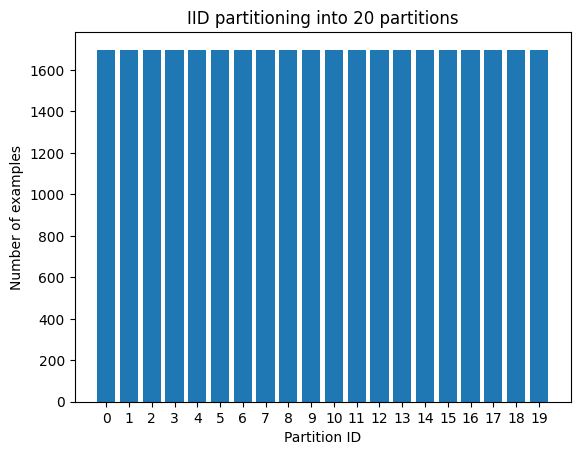

In [4]:
visualize_partitions(fds)

#### 3. Client and Server

* Load the tokenizer and other components.

In [5]:
(
tokenizer,
data_collator,
formatting_prompts_func,
) = get_tokenizer_and_data_collator_and_propt_formatting(
    cfg.model.name, 
    cfg.model.use_fast_tokenizer,
    cfg.train.padding_side,
)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


* Define the client.

In [6]:
save_path = "./my_fl_model"
client = fl.client.ClientApp(
    client_fn=gen_client_fn(
        fds,
        tokenizer,
        formatting_prompts_func,
        data_collator,
        cfg.model, 
        cfg.train, 
        save_path,
    ),
    mods=[fixedclipping_mod] 
)

> Note: The ```gen_client_fn``` function is provided for your use. You can find it in the utils folder > ```utils.py```

* Define the server function and add Differential Privacy.

In [7]:
def server_fn(context: Context):

    # Define the Strategy
    strategy = fl.server.strategy.FedAvg(
        min_available_clients=cfg.flower.num_clients, # total clients
        fraction_fit=cfg.flower.fraction_fit, # ratio of clients to sample
        fraction_evaluate=0.0, # No federated evaluation
        # A (optional) function used to configure a "fit()" round
        on_fit_config_fn=get_on_fit_config(),
        # A (optional) function to aggregate metrics sent by clients
        fit_metrics_aggregation_fn=fit_weighted_average,
        # A (optional) function to execute on the server after each round. 
        # In this example the function only saves the global model.
        evaluate_fn=get_evaluate_fn( 
            cfg.model,
            cfg.train.save_every_round,
            cfg.flower.num_rounds,
            save_path
        ),
    )

    # Add Differential Privacy
    sampled_clients = cfg.flower.num_clients*strategy.fraction_fit
    strategy = DifferentialPrivacyClientSideFixedClipping(
        strategy, 
        noise_multiplier=cfg.flower.dp.noise_mult,
        clipping_norm=cfg.flower.dp.clip_norm, 
        num_sampled_clients=sampled_clients
    )

    # Number of rounds to run the simulation
    num_rounds = cfg.flower.num_rounds
    config = fl.server.ServerConfig(num_rounds=num_rounds)
    
    return fl.server.ServerAppComponents(strategy=strategy, config=config) 

* Instantiate the ServerApp.

In [8]:
server = fl.server.ServerApp(server_fn=server_fn)

#### 4. Run

* Run the simulation.

> Note: This simulation might take a few minutes to complete.

In [9]:
client_resources = dict(cfg.flower.client_resources)
fl.simulation.run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=cfg.flower.num_clients,
    backend_config={"client_resources": client_resources,
                    "init_args": backend_setup}
)

INFO : Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO : 
INFO : [INIT]
INFO : Requesting initial parameters from one random client
INFO : Received initial parameters from one random client
INFO : Evaluating initial global parameters
INFO : initial parameters (loss, other metrics): 0.0, {}
INFO : 
INFO : [ROUND 1]
INFO : configure_fit: strategy sampled 4 clients (out of 20)
INFO : aggregate_fit: received 4 results and 0 failures
INFO : aggregate_fit: central DP noise with 0.0025 stdev added
INFO : fit progress: (1, 0.0, {}, 8.028429491445422)
INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [ROUND 2]
INFO : configure_fit: strategy sampled 4 clients (out of 20)
INFO : aggregate_fit: received 4 results and 0 failures
INFO : aggregate_fit: central DP noise with 0.0025 stdev added
INFO : fit progress: (2, 0.0, {}, 13.969516519457102)
INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [SUMMARY]
INFO : R

* Run the fine-tuned model. 

In [10]:
# Load the checkpoint
llm_eval = LLM_fl()

In [11]:
# Load dataset
train_dataset = load_dataset(cfg.dataset.name, split='train')
train_dataset = format_dataset(train_dataset)

# Select training example
example_index = 6

In [12]:
data_point = train_dataset[example_index]

In [13]:
# Print the prompt
llm_eval.eval(data_point['instruction'], verbose=True)

Prompt:
	What are the possible causes of low glucose and
	high C-peptide levels?


In [14]:
# Print the fine-tuned LLM response
llm_eval.print_response()

Response:
	Low glucose and high C-peptide levels can be
	caused by several factors, including:  1.
	Insulinoma: This is a rare tumor of the pancreas
	that causes the release of excessive amounts of
	insulin, which can lead to low glucose and high
	C-peptide levels. 2. Postprandial hypog


In [15]:
# Print the expected output from the medAlpaca dataset
ex_response = format_string(data_point['response'])
print(f"Expected output:\n\t{ex_response}")

Expected output:
	Low glucose and high C-peptide levels can be
	caused by an insulinoma or the use of
	sulfonylurea drugs.


#### 5. Visualize results

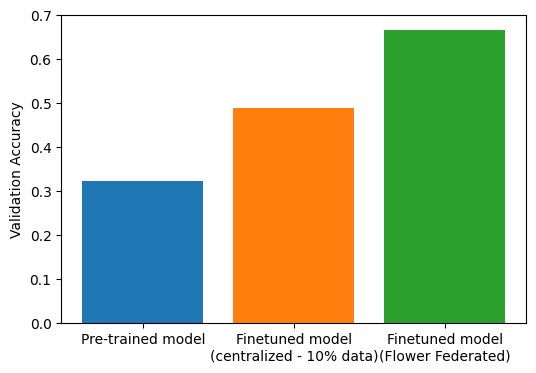

In [16]:
visualize_results(
    results=['7b/pretrained', '7b/cen_10', '7b/fl'])

* See the results if you would provide the same amount of data to the centralized finetuned-model.

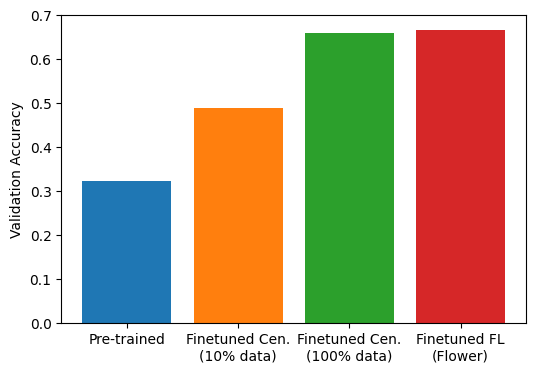

In [17]:
visualize_results(
    results=['7b/pretrained', '7b/cen_10',
             '7b/cen_full', '7b/fl'],
    compact=True)

#### 6. One more analysis

* Compute communication costs.

In [18]:
cfg = get_config("federated")

compute_communication_costs(cfg, comm_bw_mbps=20)

Full model:
	70.623 M parameters
	269.41 MB --> upload in 107.76s @ 20Mbps
Finetuned model:
	0.197 M parameters
	0.75 MB --> upload in 0.30s @ 20Mbps
Federated Learning setting: 
	Number of rounds: 2
	Number of clients per round: 4
-----------------------------------------------
Total Communication costs (Full model): 4.2 GB
Total Communication costs (Finetuning): 12.0 MB
Communication savings: 359.2x
